# Download US power output PV Watts (version 8) 

## Documentation: https://developer.nrel.gov/docs/api-key/
## https://pvwatts.nrel.gov/downloads/pvwattsv5.pdf

In [1]:
import numpy as np
import scipy as sp
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
hrh_apikey1 = 'GNoTfD5IZWwIEz24zB5Wn0aEhDvNJSep5bwapzTI'
hrh_apikey2 = 'bupvdoNsjaox9hQeCD6yufHWNf4cnM5OTNLlEBlZ'
hrh_apikey3 = 'wfaZg9uNJwCc9zJfiCXTEDnmloDEk0o6EATrdC6A'
hrh_apikey4 = '7iehBlUn3NW7rEEQYvMvB2xsinpbFQAnYGnrFoiy'
hrh_apikey5 =  'HGHXaFdKeMcknyEsmXnFMnL4aqgZK5HuZ5AV0tyG'
hrh_apikey6 = 'vPgwOy4OgMoOpnYtBsK5PyfEMwqD78HXCK5u1sNx'
data_path   = '/Users/hrh/Desktop/AI/erdos/rapower_data/'

In [3]:
# # 1. Define PVWatts parameters and your API key
# parameters = {
#     'format': 'json',
#     'system_capacity': 1000,
#     'module_type': 0,
#     'losses': 14.08,
#     'array_type': 1,
#     'tilt': 40,
#     'azimuth': 180,
#     'lat': 40.0099983215332,
#     'lon':  -105.2600021362305,
#     'dataset': 'nsrdb',
#     'radius': 25,
#     'timeframe': 'monthly',
#     'api_key': hrh_apikey1  # Replace with your API key
# }



In [4]:
# url = 'https://developer.nrel.gov/api/pvwatts/v8'

# # 2. Send request
# response = requests.get(url, params=parameters)
# data = response.json()

# # 3. Convert the output data to a DataFrame
# df = pd.DataFrame(data['outputs'])

# print(response)

In [5]:
##### Try to get data for California on a grid with lat_delta and lon_delta resolution
# lat_delta = 0.25
# lon_delta = 0.25

# # #CONUS box
# # top = 49.3457868 # north lat
# # left = -124.7844079 # west long
# # right = -66.9513812 # east long
# # bottom =  24.7433195 # south lat

# #California box
# top    = 42.009518
# bottom = 32.534156
# left   = -124.409591 
# right  =  -114.131211


### Threshold is a hyperparameter and will be applied to all variables

In [6]:
thresh_lb = 0.05 #lb = lower bound, applied to the feature ac_annual
thresh_ub = 0.95 #ub = upper bound, applied to the features elevation and slope (in this notebook)
thresh_name = '95'

## Define list of lat lon coordinates (either for CONUS or California)

<font color ='red'> PVWatts API access currently has a limit of 1000 queries per hour. So, data has to be downloaded one chunk (size<1000) at a time </font>

In [7]:
# 1. Define a list of latitudes and longitudes for CONUS
all_data = []
##### Read lats and lons CA_grid_dataframe #############
#data_path2     = '/Users/hrh/Desktop/AI/erdos/SolarFarmPrediction/data/'
#ca_gridpath    = data_path2 + 'threshold_90percentile/CA_data_version_11.csv'
data_path2     = '/Users/hrh/Desktop/AI/erdos/SolarFarmPrediction/new_data/'
ca_gridpath   = data_path2 + 'CA_data_version_2.csv'
#df_main             = pd.read_csv(ca_gridpath)
#ca_grid0            = df_main.loc[df_main['State']=='CA']
ca_grid0             = pd.read_csv(ca_gridpath)
ca_grid0

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation
0,36.177601,-120.109001,1,1.0,0.0,119.0
1,33.265202,-116.328003,1,1.0,1.0,164.0
2,34.823002,-118.348000,1,1.0,0.0,768.0
3,34.707401,-118.305000,1,1.0,0.0,748.0
4,34.708599,-118.274002,1,1.0,0.0,731.0
...,...,...,...,...,...,...
101697,34.277993,-114.160164,0,1.0,3.0,201.0
101698,34.297547,-114.160164,0,1.0,31.0,228.0
101699,34.317101,-114.160164,0,1.0,20.0,148.0
101700,34.258439,-114.138592,0,0.0,0.0,112.0


In [29]:
### Remove rows where there is no data for land_cover,slope or elevation
#ca_grid = ca_grid0.dropna(subset = ['slope','elevation','land_cover'])
ca_grid = ca_grid0.dropna(subset = ['slope','elevation'])
ca_grid

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation
0,36.177601,-120.109001,1,1.0,0.0,119.0
1,33.265202,-116.328003,1,1.0,1.0,164.0
2,34.823002,-118.348000,1,1.0,0.0,768.0
3,34.707401,-118.305000,1,1.0,0.0,748.0
4,34.708599,-118.274002,1,1.0,0.0,731.0
...,...,...,...,...,...,...
101697,34.277993,-114.160164,0,1.0,3.0,201.0
101698,34.297547,-114.160164,0,1.0,31.0,228.0
101699,34.317101,-114.160164,0,1.0,20.0,148.0
101700,34.258439,-114.138592,0,0.0,0.0,112.0


In [9]:
#Check if it worked
ca_grid['slope'].isna()

0         False
1         False
2         False
3         False
4         False
          ...  
101697    False
101698    False
101699    False
101700    False
101701    False
Name: slope, Length: 101643, dtype: bool

In [10]:
#ca_grid_usable      = ca_grid.loc[ca_grid['land_cover']==1.0]
ca_coords           = list(zip(ca_grid['Latitude'], ca_grid['Longitude']))
#Check if ca_coords are within california grid box
ca_lats = [item[0] for item in ca_coords] 
ca_lons = [item[1] for item in ca_coords]
(min(ca_lats),max(ca_lats)),(min(ca_lons),max(ca_lons))
ca_grid

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation
0,36.177601,-120.109001,1,1.0,0.0,119.0
1,33.265202,-116.328003,1,1.0,1.0,164.0
2,34.823002,-118.348000,1,1.0,0.0,768.0
3,34.707401,-118.305000,1,1.0,0.0,748.0
4,34.708599,-118.274002,1,1.0,0.0,731.0
...,...,...,...,...,...,...
101697,34.277993,-114.160164,0,1.0,3.0,201.0
101698,34.297547,-114.160164,0,1.0,31.0,228.0
101699,34.317101,-114.160164,0,1.0,20.0,148.0
101700,34.258439,-114.138592,0,0.0,0.0,112.0


### Reduce the grid points to those with solar farms and a a few sites with no solar farms

In [11]:
solar_farms = ca_grid.loc[ca_grid['Solar_farm_present']==1]
solar_farms

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation
0,36.177601,-120.109001,1,1.0,0.0,119.0
1,33.265202,-116.328003,1,1.0,1.0,164.0
2,34.823002,-118.348000,1,1.0,0.0,768.0
3,34.707401,-118.305000,1,1.0,0.0,748.0
4,34.708599,-118.274002,1,1.0,0.0,731.0
...,...,...,...,...,...,...
466,34.564400,-117.694000,1,1.0,1.0,914.0
467,39.651600,-121.650002,1,1.0,3.0,102.0
468,34.687302,-118.320000,1,1.0,1.0,772.0
469,32.660400,-115.629997,1,1.0,0.0,-3.0


### Let us pick locations where only one feature is restricting:

#### 1) Slope 2) Elevation 3) Land Cover

### The thresholds will be set at thresh_ub percentile of the feature set of existing solar farm locations

In [12]:
slope_threshold       = solar_farms['slope'].quantile(thresh_ub)
elevation_threshold   = solar_farms['elevation'].quantile(thresh_ub)
print(slope_threshold,elevation_threshold)  

3.0 915.0


In [13]:
np.sort(solar_farms['slope'])

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [14]:
high_slope = ca_grid.loc[(ca_grid['Solar_farm_present']!=1) & (ca_grid['slope']>=slope_threshold) &(ca_grid['land_cover']!=0)]
high_slope

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation
505,40.437539,-124.407129,0,1.0,22.0,76.0
529,40.417985,-124.385556,0,1.0,16.0,270.0
530,40.437539,-124.385556,0,1.0,22.0,218.0
531,40.457093,-124.385556,0,1.0,8.0,193.0
532,40.476647,-124.385556,0,1.0,8.0,69.0
...,...,...,...,...,...,...
101695,34.317101,-114.181737,0,1.0,33.0,370.0
101697,34.277993,-114.160164,0,1.0,3.0,201.0
101698,34.297547,-114.160164,0,1.0,31.0,228.0
101699,34.317101,-114.160164,0,1.0,20.0,148.0


In [15]:
high_elevation = ca_grid.loc[(ca_grid['Solar_farm_present']!=1) & (ca_grid['elevation']>=elevation_threshold) & (ca_grid['slope']<slope_threshold) & (ca_grid['land_cover']!=0)]
high_elevation 

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation
2474,41.923652,-123.889387,0,1.0,2.0,1011.0
3445,40.593972,-123.738380,0,1.0,2.0,1140.0
5425,40.241998,-123.479509,0,1.0,0.0,1512.0
5459,40.906838,-123.479509,0,1.0,2.0,1248.0
5949,40.281106,-123.414791,0,1.0,2.0,955.0
...,...,...,...,...,...,...
98789,35.099266,-115.023067,0,1.0,0.0,1037.0
98790,35.118820,-115.023067,0,1.0,1.0,1053.0
98791,35.138374,-115.023067,0,1.0,0.0,1071.0
98920,35.040604,-115.001494,0,1.0,2.0,954.0


In [16]:
land_cover = ca_grid.loc[(ca_grid['Solar_farm_present']!=1) & (ca_grid['elevation'] < elevation_threshold) & (ca_grid['slope']<slope_threshold) & (ca_grid['land_cover']==0)]
land_cover

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation
471,40.417985,-124.471847,0,0.0,0.0,0.0
472,40.437539,-124.471847,0,0.0,0.0,0.0
473,40.457093,-124.471847,0,0.0,0.0,0.0
474,40.398431,-124.450274,0,0.0,0.0,0.0
475,40.417985,-124.450274,0,0.0,0.0,0.0
...,...,...,...,...,...,...
101577,34.551751,-114.397462,0,0.0,0.0,137.0
101626,34.434426,-114.332745,0,0.0,0.0,137.0
101690,34.356210,-114.203309,0,0.0,0.0,138.0
101696,34.336656,-114.181737,0,0.0,0.0,138.0


### Let us pick locations with low elevation, low slope and no land cover restrictions 

In [17]:
## I am calling these points rad_limited because they are not infeasible due to any other feature considered so far.
rad_limited = ca_grid.loc[(ca_grid['Solar_farm_present']!=1) & (ca_grid['elevation'] < elevation_threshold) & (ca_grid['slope']<slope_threshold) & (ca_grid['land_cover']!=0)]
rad_limited

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation
559,40.437539,-124.363984,0,1.0,1.0,379.0
620,40.300660,-124.320839,0,1.0,1.0,8.0
635,40.593972,-124.320839,0,1.0,1.0,2.0
636,40.613526,-124.320839,0,1.0,0.0,1.0
658,40.320215,-124.299266,0,1.0,2.0,20.0
...,...,...,...,...,...,...
101641,34.180223,-114.289600,0,1.0,1.0,147.0
101643,34.219331,-114.289600,0,1.0,1.0,257.0
101665,34.180223,-114.246454,0,1.0,1.0,112.0
101666,34.199777,-114.246454,0,1.0,2.0,146.0


In [18]:
## Number of locations to be sampled from rad_limited , 800 for each feature slope,elevation and land_cover ##############
radlim_size = 5000 - (len(solar_farms) + 2400)
radlim_size

2129

### Sample points from the dataframes to have a list of 5000 locations and set the labels

In [19]:
## Add extra column called fearture violated 
sample_high_elevation                       = high_elevation.sample(800,random_state=42)
sample_high_elevation['Solar_farm_present'] = 0
sample_high_elevation['feature_violated']   = 'elevation'
sample_high_elevation  

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated
41212,40.359323,-120.631931,0,1.0,2.0,1303.0,elevation
45033,40.378877,-120.373061,0,1.0,1.0,1233.0,elevation
36915,40.985054,-120.890802,0,1.0,0.0,1720.0,elevation
64144,38.051937,-118.862982,0,1.0,1.0,1986.0,elevation
72990,36.565825,-117.978507,0,1.0,0.0,1117.0,elevation
...,...,...,...,...,...,...,...
41261,41.317474,-120.631931,0,1.0,0.0,1496.0,elevation
82857,34.610413,-116.964597,0,1.0,2.0,986.0,elevation
27678,41.102379,-121.494834,0,1.0,0.0,1012.0,elevation
40456,40.554864,-120.675076,0,1.0,2.0,1521.0,elevation


In [20]:
sample_land_cover                       = land_cover.sample(800, random_state=42)
sample_land_cover['Solar_farm_present'] = 0
sample_land_cover['feature_violated']   = 'land_cover'
sample_land_cover      

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated
15871,38.130154,-122.379308,0,0.0,0.0,0.0,land_cover
40559,35.079712,-120.653504,0,0.0,0.0,0.0,land_cover
5863,38.599452,-123.414791,0,0.0,0.0,0.0,land_cover
10071,38.012829,-122.940195,0,0.0,0.0,0.0,land_cover
479,40.496202,-124.450274,0,0.0,0.0,0.0,land_cover
...,...,...,...,...,...,...,...
43240,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover
10743,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover
39076,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover
101314,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover


In [21]:
sample_high_slope                       = high_slope.sample(800, random_state=42)
sample_high_slope['Solar_farm_present'] = 0
sample_high_slope['feature_violated']   = 'slope'
sample_high_slope

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated
80378,34.297547,-117.201895,0,1.0,6.0,1480.0,slope
71904,35.392578,-118.086370,0,1.0,4.0,1166.0,slope
13268,38.638561,-122.616607,0,1.0,25.0,553.0,slope
96524,35.177482,-115.368227,0,1.0,19.0,1780.0,slope
83372,36.135634,-116.921452,0,1.0,6.0,217.0,slope
...,...,...,...,...,...,...,...
68523,37.074232,-118.431531,0,1.0,31.0,3335.0,slope
28061,36.252959,-121.451689,0,1.0,21.0,504.0,slope
74704,34.180223,-117.784354,0,1.0,13.0,646.0,slope
65120,36.057418,-118.755119,0,1.0,37.0,614.0,slope


In [22]:
sample_rad_limited = rad_limited.sample(radlim_size,random_state=42)

### Combine data frames 

In [23]:
ca_grid_sampled = pd.concat([sample_rad_limited,sample_high_elevation,sample_high_slope,solar_farms,sample_land_cover])
ca_grid_sampled

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated
30111,38.638561,-121.322253,0,1.0,2.0,37.0,NaN
27893,39.146968,-121.473261,0,1.0,0.0,27.0,NaN
93767,33.632707,-115.734961,0,1.0,2.0,561.0,NaN
94863,32.850543,-115.583953,0,1.0,0.0,-18.0,NaN
70383,33.886911,-118.237378,0,1.0,1.0,27.0,NaN
...,...,...,...,...,...,...,...
43240,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover
10743,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover
39076,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover
101314,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover


In [25]:
###### Check #############
ca_grid_sampled.loc[ca_grid_sampled['feature_violated']=='elevation']

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated
41212,40.359323,-120.631931,0,1.0,2.0,1303.0,elevation
45033,40.378877,-120.373061,0,1.0,1.0,1233.0,elevation
36915,40.985054,-120.890802,0,1.0,0.0,1720.0,elevation
64144,38.051937,-118.862982,0,1.0,1.0,1986.0,elevation
72990,36.565825,-117.978507,0,1.0,0.0,1117.0,elevation
...,...,...,...,...,...,...,...
41261,41.317474,-120.631931,0,1.0,0.0,1496.0,elevation
82857,34.610413,-116.964597,0,1.0,2.0,986.0,elevation
27678,41.102379,-121.494834,0,1.0,0.0,1012.0,elevation
40456,40.554864,-120.675076,0,1.0,2.0,1521.0,elevation


In [26]:
#### Get lat and lons 
ca_coords_sample           = list(zip(ca_grid_sampled['Latitude'], ca_grid_sampled['Longitude']))
len(ca_coords_sample )
########
ca_coords_sample1 = ca_coords_sample[0:1000]
ca_coords_sample2 = ca_coords_sample[1000:2000]
ca_coords_sample3 = ca_coords_sample[2000:3000]
ca_coords_sample4 = ca_coords_sample[3000:4000]
ca_coords_sample5 = ca_coords_sample[4000:]
len(ca_coords_sample3)

1000

In [49]:
%%time
df = pd.DataFrame()
for (lat,lon) in ca_coords_sample5:
        
        parameters = {
            'format': 'json',
            'system_capacity': 1000, #1000kW = 1 MW, 1 MW or greater is considered utility-scale
            'module_type': 0,       # 0- Standard module, 1- Permium, 2-Thin film
            'losses': 14,           # Losses in percentage
            'array_type': 0,        # Open Rack: Also known as ground mount.
            'tilt': 40,
            'azimuth': 180,         # This means that the solar array is facing South in the Northeren Hemisphere
            'lat': lat,
            'lon': lon,
            'dataset': 'nsrdb',      #tmy2 is 1960-1990, tmy3 is 1990-2005
            'radius': 100,            # 0-Pick the station nearest to the given (lat,lon),e.g: 50 -50 miles
            'timeframe': 'monthly',
            'api_key': hrh_apikey5
        }

        url = 'https://developer.nrel.gov/api/pvwatts/v8'
        response = requests.get(url, params=parameters)
        data = response.json()
             
        # Extract and append relevant data to the all_data list
        # Extract relevant data
        #print('Processing (lat,lon):',lat,lon,'\n')
        
        # Check if 'outputs' is in the data
        if 'outputs' not in data:
            print(f"No data available for latitude {lat} and longitude {lon}")
            continue

        output_data = data['outputs']
        input_data  = data['inputs']

        output_data['latitude']  = input_data['lat']
        output_data['longitude'] = input_data['lon']
        all_data.append(output_data)
        
        
# Convert all_data to a DataFrame
df = pd.DataFrame(all_data)

print(df)

                                             ac_monthly  \
0     [84883.06914835521, 110107.3007904001, 142457....   
1     [78866.77428118252, 106080.1644945415, 124079....   
2     [142033.6075897373, 135669.0721331215, 169827....   
3     [142250.309592729, 145540.4466112001, 169827.4...   
4     [123194.0549525465, 121968.199271841, 148417.1...   
...                                                 ...   
4995  [134294.313590256, 118366.24124287, 149754.498...   
4996  [86549.00961829678, 108134.5256253014, 127573....   
4997  [113917.7039648926, 111119.0424322115, 148308....   
4998  [139332.6846621154, 142410.7072380826, 166391....   
4999  [93175.08528784048, 103355.3357037224, 129479....   

                                            poa_monthly  \
0     [104.6620668695758, 137.671252552197, 181.5298...   
1     [99.45905129543517, 133.9026315700545, 159.580...   
2     [176.9045521906041, 169.7386789021357, 221.042...   
3     [179.1055874454835, 186.1198841765338, 223.688...

In [50]:
df

,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,solrad_annual,capacity_factor,latitude,longitude
0,"[84883.06914835521, 110107.3007904001, 142457....","[104.6620668695758, 137.671252552197, 181.5298...","[3.376195705470185, 4.916830448292751, 5.85580...","[89177.54404926489, 115410.2864073284, 149285....",1.598632e+06,5.732396,18.249219,38.63856071966661,-121.32225320345118
1,"[78866.77428118252, 106080.1644945415, 124079....","[99.45905129543517, 133.9026315700545, 159.580...","[3.208356493401135, 4.782236841787659, 5.14776...","[82933.84836181221, 111212.6071361726, 130119....",1.547354e+06,5.648400,17.663854,39.1469676944991,-121.4732611026316
2,"[142033.6075897373, 135669.0721331215, 169827....","[176.9045521906041, 169.7386789021357, 221.042...","[5.706598457761423, 6.062095675076274, 7.13041...","[148606.6602928677, 142527.3934126461, 177911....",1.835391e+06,6.640421,20.951948,33.632707429008306,-115.73496093377555
3,"[142250.309592729, 145540.4466112001, 169827.4...","[179.1055874454835, 186.1198841765338, 223.688...","[5.777599595015598, 6.647138720590493, 7.21576...","[148922.2969679596, 152201.7710591838, 177685....",1.802739e+06,6.666664,20.579213,32.85054285234295,-115.58395303459514
4,"[123194.0549525465, 121968.199271841, 148417.1...","[154.0335887228755, 155.190735588352, 191.3896...","[4.968825442673403, 5.542526271012572, 6.17385...","[128993.2732027951, 127672.1091778474, 155507....",1.671830e+06,5.956900,19.084820,33.88691091642455,-118.2373775487654
...,...,...,...,...,...,...,...,...,...
4995,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,5.789799,19.202002,34.414872005673665,-120.50249603647174
4996,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,5.817975,17.838677,39.0296430079993,-122.87547730930694
4997,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,5.749070,18.751075,35.15792835350576,-120.73979416375526
4998,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,6.543961,20.400983,33.61315331459167,-114.5268977403322


In [51]:
# Save file in the appropriate threshold folder
threshold_path = data_path2 + 'threshold_'+thresh_name+'percentile/'
print(threshold_path)
df.to_csv(threshold_path +'nsrdb_monthly_chunk5.csv',index=False)

/Users/hrh/Desktop/AI/erdos/SolarFarmPrediction/new_data/threshold_95percentile/


In [52]:
df_check = pd.read_csv(threshold_path +'nsrdb_monthly_chunk5.csv')
df_check

,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,solrad_annual,capacity_factor,latitude,longitude
0,"[84883.06914835521, 110107.3007904001, 142457....","[104.6620668695758, 137.671252552197, 181.5298...","[3.376195705470185, 4.916830448292751, 5.85580...","[89177.54404926489, 115410.2864073284, 149285....",1.598632e+06,5.732396,18.249219,38.638561,-121.322253
1,"[78866.77428118252, 106080.1644945415, 124079....","[99.45905129543517, 133.9026315700545, 159.580...","[3.208356493401135, 4.782236841787659, 5.14776...","[82933.84836181221, 111212.6071361726, 130119....",1.547354e+06,5.648400,17.663854,39.146968,-121.473261
2,"[142033.6075897373, 135669.0721331215, 169827....","[176.9045521906041, 169.7386789021357, 221.042...","[5.706598457761423, 6.062095675076274, 7.13041...","[148606.6602928677, 142527.3934126461, 177911....",1.835391e+06,6.640421,20.951948,33.632707,-115.734961
3,"[142250.309592729, 145540.4466112001, 169827.4...","[179.1055874454835, 186.1198841765338, 223.688...","[5.777599595015598, 6.647138720590493, 7.21576...","[148922.2969679596, 152201.7710591838, 177685....",1.802739e+06,6.666664,20.579213,32.850543,-115.583953
4,"[123194.0549525465, 121968.199271841, 148417.1...","[154.0335887228755, 155.190735588352, 191.3896...","[4.968825442673403, 5.542526271012572, 6.17385...","[128993.2732027951, 127672.1091778474, 155507....",1.671830e+06,5.956900,19.084820,33.886911,-118.237378
...,...,...,...,...,...,...,...,...,...
4995,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,5.789799,19.202002,34.414872,-120.502496
4996,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,5.817975,17.838677,39.029643,-122.875477
4997,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,5.749070,18.751075,35.157928,-120.739794
4998,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,6.543961,20.400983,33.613153,-114.526898


In [53]:
# df0 = df.drop_duplicates(subset=['latitude','longitude'])
# df0

In [53]:
df_check.to_csv(threshold_path +'nsrdb_monthly.csv',index=False)

In [54]:
# ca_rad1 = pd.read_csv(data_path2+'nsrdb_monthly_chunk1.csv')
ca_rad = pd.read_csv(threshold_path +'nsrdb_monthly.csv')
ca_rad

,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,solrad_annual,capacity_factor,latitude,longitude
0,"[84883.06914835521, 110107.3007904001, 142457....","[104.6620668695758, 137.671252552197, 181.5298...","[3.376195705470185, 4.916830448292751, 5.85580...","[89177.54404926489, 115410.2864073284, 149285....",1.598632e+06,5.732396,18.249219,38.638561,-121.322253
1,"[78866.77428118252, 106080.1644945415, 124079....","[99.45905129543517, 133.9026315700545, 159.580...","[3.208356493401135, 4.782236841787659, 5.14776...","[82933.84836181221, 111212.6071361726, 130119....",1.547354e+06,5.648400,17.663854,39.146968,-121.473261
2,"[142033.6075897373, 135669.0721331215, 169827....","[176.9045521906041, 169.7386789021357, 221.042...","[5.706598457761423, 6.062095675076274, 7.13041...","[148606.6602928677, 142527.3934126461, 177911....",1.835391e+06,6.640421,20.951948,33.632707,-115.734961
3,"[142250.309592729, 145540.4466112001, 169827.4...","[179.1055874454835, 186.1198841765338, 223.688...","[5.777599595015598, 6.647138720590493, 7.21576...","[148922.2969679596, 152201.7710591838, 177685....",1.802739e+06,6.666664,20.579213,32.850543,-115.583953
4,"[123194.0549525465, 121968.199271841, 148417.1...","[154.0335887228755, 155.190735588352, 191.3896...","[4.968825442673403, 5.542526271012572, 6.17385...","[128993.2732027951, 127672.1091778474, 155507....",1.671830e+06,5.956900,19.084820,33.886911,-118.237378
...,...,...,...,...,...,...,...,...,...
4995,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,5.789799,19.202002,34.414872,-120.502496
4996,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,5.817975,17.838677,39.029643,-122.875477
4997,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,5.749070,18.751075,35.157928,-120.739794
4998,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,6.543961,20.400983,33.613153,-114.526898


In [55]:
# Convert DataFrame to GeoDataFrame
geometry       = [Point(xy) for xy in zip(ca_rad['longitude'], ca_rad['latitude'])]
geo_df_rad     = gpd.GeoDataFrame(ca_rad, geometry=geometry,crs = "EPSG:4326")

EPSG:4326


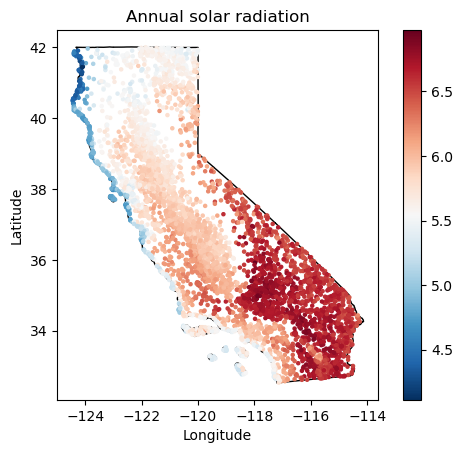

In [56]:
# Load the California shapefile
ca_shapfile_path = data_path+ 'ca_state_boundary/CA_State_TIGER2016.shp'
ca_shape         = gpd.read_file(ca_shapfile_path)
ca_shape         = ca_shape.to_crs("EPSG:4326")
print(ca_shape.crs)


# Plot the county boundaries
fig, ax = plt.subplots()
ca_shape.plot(ax=ax, color='white', edgecolor='black')

# Plot solar_rad data on top of the county boundaries
geo_df_rad.plot(ax=ax, column='solrad_annual', legend=True, markersize=5, cmap='RdBu_r',  missing_kwds={
        "color": "white",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    })


# geo_df_rad.plot(ax=ax, column='solrad_annual', legend=True, markersize=50, cmap='OrRd', alpha=0.5)

# Add titles and labels as needed
plt.title("Annual solar radiation")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the plot
plt.show()

EPSG:4326


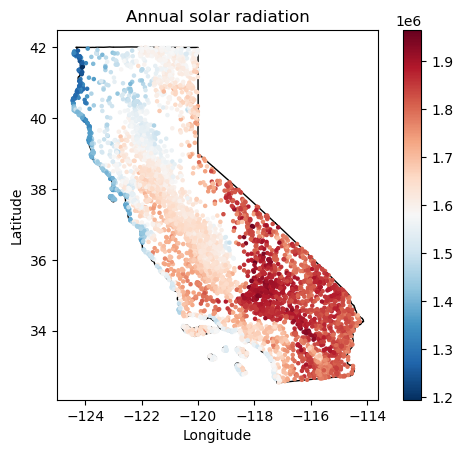

In [57]:
# Load the California shapefile
ca_shapfile_path = data_path+ 'ca_state_boundary/CA_State_TIGER2016.shp'
ca_shape         = gpd.read_file(ca_shapfile_path)
ca_shape         = ca_shape.to_crs("EPSG:4326")
print(ca_shape.crs)


# Plot the county boundaries
fig, ax = plt.subplots()
ca_shape.plot(ax=ax, color='white', edgecolor='black')

# Plot solar_rad data on top of the county boundaries
geo_df_rad.plot(ax=ax, column='ac_annual', legend=True, markersize=5, cmap='RdBu_r',  missing_kwds={
        "color": "white",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    })


# geo_df_rad.plot(ax=ax, column='solrad_annual', legend=True, markersize=50, cmap='OrRd', alpha=0.5)

# Add titles and labels as needed
plt.title("Annual solar radiation")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the plot
plt.show()

## Add data to big dataframe

#### Find threshold for ac_annual. Exclude the bottom thresh_lb * 100 %

In [58]:
ac_annual_threshold = geo_df_rad['ac_annual'].quantile(q=thresh_lb)
ac_annual_threshold 

1457208.376409882

In [59]:
# Ensure both GeoDataFrames have the same CRS
# Convert ca_features to a GeoDataFrame
gdf_ca_features = gpd.GeoDataFrame(
    ca_grid_sampled, 
    geometry=gpd.points_from_xy(ca_grid_sampled.Longitude, ca_grid_sampled.Latitude),
    crs="EPSG:4326"
)

# Ensure ca_rad is a GeoDataFrame with the same CRS
gdf_ca_rad = gpd.GeoDataFrame(
    ca_rad,
    geometry=gpd.points_from_xy(ca_rad.longitude, ca_rad.latitude),
    crs="EPSG:4326"
)

# Reproject to a suitable projected CRS for accurate distance calculations
gdf_ca_features = gdf_ca_features.to_crs("EPSG:3310")
gdf_ca_rad      = gdf_ca_rad.to_crs("EPSG:3310")


In [60]:
# Perform the spatial join to find the nearest neighbors and get their 'elevation'
ca_features_with_solar_data = gpd.sjoin_nearest(gdf_ca_features, gdf_ca_rad[['geometry', 'solrad_annual','ac_monthly', 'poa_monthly', 'solrad_monthly','dc_monthly','ac_annual']],\
                                                how='left', distance_col='distance')
ca_features_with_solar_data

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,geometry,index_right,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,distance
30111,38.638561,-121.322253,0,1.0,2.0,37.0,NaN,POINT (-114965.109 69966.408),0,5.732396,"[84883.06914835521, 110107.3007904001, 142457....","[104.6620668695758, 137.671252552197, 181.5298...","[3.376195705470185, 4.916830448292751, 5.85580...","[89177.54404926489, 115410.2864073284, 149285....",1.598632e+06,0.0
27893,39.146968,-121.473261,0,1.0,0.0,27.0,NaN,POINT (-127215.578 126661.719),1,5.648400,"[78866.77428118252, 106080.1644945415, 124079....","[99.45905129543517, 133.9026315700545, 159.580...","[3.208356493401135, 4.782236841787659, 5.14776...","[82933.84836181221, 111212.6071361726, 130119....",1.547354e+06,0.0
93767,33.632707,-115.734961,0,1.0,2.0,561.0,NaN,POINT (395723.453 -477996.803),2,6.640421,"[142033.6075897373, 135669.0721331215, 169827....","[176.9045521906041, 169.7386789021357, 221.042...","[5.706598457761423, 6.062095675076274, 7.13041...","[148606.6602928677, 142527.3934126461, 177911....",1.835391e+06,0.0
94863,32.850543,-115.583953,0,1.0,0.0,-18.0,NaN,POINT (413760.377 -563940.891),3,6.666664,"[142250.309592729, 145540.4466112001, 169827.4...","[179.1055874454835, 186.1198841765338, 223.688...","[5.777599595015598, 6.647138720590493, 7.21576...","[148922.2969679596, 152201.7710591838, 177685....",1.802739e+06,0.0
70383,33.886911,-118.237378,0,1.0,1.0,27.0,NaN,POINT (163063.336 -457194.260),4,5.956900,"[123194.0549525465, 121968.199271841, 148417.1...","[154.0335887228755, 155.190735588352, 191.3896...","[4.968825442673403, 5.542526271012572, 6.17385...","[128993.2732027951, 127672.1091778474, 155507....",1.671830e+06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43240,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,POINT (-46178.591 -400015.656),4995,5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,0.0
10743,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,POINT (-248663.872 116405.088),4996,5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,0.0
39076,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,POINT (-67341.976 -317389.303),4997,5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,0.0
101314,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,POINT (507825.659 -474405.559),4998,6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,0.0


In [61]:


# If you don't need the distance information, drop the 'distance' column
ca_features_with_solar_data.drop(columns=['index_right', 'distance',], inplace=True)

# Optionally, project back to geographic CRS if needed for other purposes
ca_features_with_solar_data = ca_features_with_solar_data.to_crs("EPSG:4326")

ca_features_with_solar_data

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,geometry,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual
30111,38.638561,-121.322253,0,1.0,2.0,37.0,NaN,POINT (-121.32225 38.63856),5.732396,"[84883.06914835521, 110107.3007904001, 142457....","[104.6620668695758, 137.671252552197, 181.5298...","[3.376195705470185, 4.916830448292751, 5.85580...","[89177.54404926489, 115410.2864073284, 149285....",1.598632e+06
27893,39.146968,-121.473261,0,1.0,0.0,27.0,NaN,POINT (-121.47326 39.14697),5.648400,"[78866.77428118252, 106080.1644945415, 124079....","[99.45905129543517, 133.9026315700545, 159.580...","[3.208356493401135, 4.782236841787659, 5.14776...","[82933.84836181221, 111212.6071361726, 130119....",1.547354e+06
93767,33.632707,-115.734961,0,1.0,2.0,561.0,NaN,POINT (-115.73496 33.63271),6.640421,"[142033.6075897373, 135669.0721331215, 169827....","[176.9045521906041, 169.7386789021357, 221.042...","[5.706598457761423, 6.062095675076274, 7.13041...","[148606.6602928677, 142527.3934126461, 177911....",1.835391e+06
94863,32.850543,-115.583953,0,1.0,0.0,-18.0,NaN,POINT (-115.58395 32.85054),6.666664,"[142250.309592729, 145540.4466112001, 169827.4...","[179.1055874454835, 186.1198841765338, 223.688...","[5.777599595015598, 6.647138720590493, 7.21576...","[148922.2969679596, 152201.7710591838, 177685....",1.802739e+06
70383,33.886911,-118.237378,0,1.0,1.0,27.0,NaN,POINT (-118.23738 33.88691),5.956900,"[123194.0549525465, 121968.199271841, 148417.1...","[154.0335887228755, 155.190735588352, 191.3896...","[4.968825442673403, 5.542526271012572, 6.17385...","[128993.2732027951, 127672.1091778474, 155507....",1.671830e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43240,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,POINT (-120.50250 34.41487),5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06
10743,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,POINT (-122.87548 39.02964),5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06
39076,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,POINT (-120.73979 35.15793),5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06
101314,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,POINT (-114.52690 33.61315),6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06


In [62]:
##Set value where ac_annual is below threshold
ac_annual_low   = (ca_features_with_solar_data['ac_annual']<=ac_annual_threshold) & (ca_features_with_solar_data['Solar_farm_present']!=1) \
& (ca_features_with_solar_data['elevation'] < elevation_threshold) \
& (ca_features_with_solar_data['slope']<slope_threshold) & (ca_features_with_solar_data['land_cover']!=0)

ca_features_with_solar_data.loc[ac_annual_low,'Solar_farm_present']=0
ca_features_with_solar_data.loc[ac_annual_low,'feature_violated']='ac_annual'
ca_features_with_solar_data

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,geometry,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual
30111,38.638561,-121.322253,0,1.0,2.0,37.0,NaN,POINT (-121.32225 38.63856),5.732396,"[84883.06914835521, 110107.3007904001, 142457....","[104.6620668695758, 137.671252552197, 181.5298...","[3.376195705470185, 4.916830448292751, 5.85580...","[89177.54404926489, 115410.2864073284, 149285....",1.598632e+06
27893,39.146968,-121.473261,0,1.0,0.0,27.0,NaN,POINT (-121.47326 39.14697),5.648400,"[78866.77428118252, 106080.1644945415, 124079....","[99.45905129543517, 133.9026315700545, 159.580...","[3.208356493401135, 4.782236841787659, 5.14776...","[82933.84836181221, 111212.6071361726, 130119....",1.547354e+06
93767,33.632707,-115.734961,0,1.0,2.0,561.0,NaN,POINT (-115.73496 33.63271),6.640421,"[142033.6075897373, 135669.0721331215, 169827....","[176.9045521906041, 169.7386789021357, 221.042...","[5.706598457761423, 6.062095675076274, 7.13041...","[148606.6602928677, 142527.3934126461, 177911....",1.835391e+06
94863,32.850543,-115.583953,0,1.0,0.0,-18.0,NaN,POINT (-115.58395 32.85054),6.666664,"[142250.309592729, 145540.4466112001, 169827.4...","[179.1055874454835, 186.1198841765338, 223.688...","[5.777599595015598, 6.647138720590493, 7.21576...","[148922.2969679596, 152201.7710591838, 177685....",1.802739e+06
70383,33.886911,-118.237378,0,1.0,1.0,27.0,NaN,POINT (-118.23738 33.88691),5.956900,"[123194.0549525465, 121968.199271841, 148417.1...","[154.0335887228755, 155.190735588352, 191.3896...","[4.968825442673403, 5.542526271012572, 6.17385...","[128993.2732027951, 127672.1091778474, 155507....",1.671830e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43240,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,POINT (-120.50250 34.41487),5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06
10743,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,POINT (-122.87548 39.02964),5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06
39076,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,POINT (-120.73979 35.15793),5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06
101314,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,POINT (-114.52690 33.61315),6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06


In [63]:
ca_features_with_solar_data.loc[ca_features_with_solar_data['Solar_farm_present'].isna()]

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,geometry,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual


### Finally, save this data as a CSV file

In [68]:
ca_features_with_solar_data.drop(columns='geometry').to_csv(threshold_path +'ca_data_version_3.csv', index=False)

In [69]:
ca_features_with_solar_data_check = pd.read_csv(threshold_path +'ca_data_version_3.csv')
ca_features_with_solar_data_check 

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual
0,38.638561,-121.322253,0,1.0,2.0,37.0,NaN,5.732396,"[84883.06914835521, 110107.3007904001, 142457....","[104.6620668695758, 137.671252552197, 181.5298...","[3.376195705470185, 4.916830448292751, 5.85580...","[89177.54404926489, 115410.2864073284, 149285....",1.598632e+06
1,39.146968,-121.473261,0,1.0,0.0,27.0,NaN,5.648400,"[78866.77428118252, 106080.1644945415, 124079....","[99.45905129543517, 133.9026315700545, 159.580...","[3.208356493401135, 4.782236841787659, 5.14776...","[82933.84836181221, 111212.6071361726, 130119....",1.547354e+06
2,33.632707,-115.734961,0,1.0,2.0,561.0,NaN,6.640421,"[142033.6075897373, 135669.0721331215, 169827....","[176.9045521906041, 169.7386789021357, 221.042...","[5.706598457761423, 6.062095675076274, 7.13041...","[148606.6602928677, 142527.3934126461, 177911....",1.835391e+06
3,32.850543,-115.583953,0,1.0,0.0,-18.0,NaN,6.666664,"[142250.309592729, 145540.4466112001, 169827.4...","[179.1055874454835, 186.1198841765338, 223.688...","[5.777599595015598, 6.647138720590493, 7.21576...","[148922.2969679596, 152201.7710591838, 177685....",1.802739e+06
4,33.886911,-118.237378,0,1.0,1.0,27.0,NaN,5.956900,"[123194.0549525465, 121968.199271841, 148417.1...","[154.0335887228755, 155.190735588352, 191.3896...","[4.968825442673403, 5.542526271012572, 6.17385...","[128993.2732027951, 127672.1091778474, 155507....",1.671830e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06
4996,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06
4997,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06
4998,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06


In [71]:
ca_features_with_solar_data_check.loc[(ca_features_with_solar_data_check['feature_violated']=='elevation')]

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual
2129,40.359323,-120.631931,0,1.0,2.0,1303.0,elevation,5.800638,"[103351.3635653951, 100500.2908635284, 144547....","[125.4477454750849, 123.7115319965838, 181.497...","[4.046701466938223, 4.418268999877993, 5.85474...","[108398.8087866204, 106465.7720028536, 152476....",1.622821e+06
2130,40.378877,-120.373061,0,1.0,1.0,1233.0,elevation,5.837898,"[100852.3082413978, 106494.0689454024, 147919....","[122.2390688486897, 131.6625069065885, 186.520...","[3.943195769312569, 4.702232389521017, 6.01678...","[105809.8420581117, 111629.9004175349, 155353....",1.630034e+06
2131,40.985054,-120.890802,0,1.0,0.0,1720.0,elevation,5.669324,"[99722.61500801894, 109183.9367829212, 133277....","[117.9534011360403, 133.9159953835858, 165.822...","[3.804948423743235, 4.782714120842349, 5.34911...","[104649.9178305522, 116216.5982579751, 140785....",1.616480e+06
2132,38.051937,-118.862982,0,1.0,1.0,1986.0,elevation,6.289559,"[115897.8822387333, 135441.9611633163, 167457....","[140.6816164551205, 165.7430776421407, 209.935...","[4.538116659842596, 5.919395630076456, 6.77210...","[122718.5112051391, 144540.066174457, 178085.4...",1.789784e+06
2133,36.565825,-117.978507,0,1.0,0.0,1117.0,elevation,6.658378,"[134765.4734673611, 138704.715076888, 178166.1...","[165.7723954815547, 172.4013888447478, 228.484...","[5.347496628437249, 6.157192458740993, 7.37047...","[141770.0925763517, 145643.535554575, 186725.2...",1.854907e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,41.317474,-120.631931,0,1.0,0.0,1496.0,elevation,5.609309,"[100112.9104320916, 107205.1854075825, 140681....","[118.4070288637792, 131.0064007636165, 174.189...","[3.819581576250942, 4.678800027272017, 5.61903...","[105089.1222966419, 113679.7550695216, 147897....",1.603751e+06
2925,34.610413,-116.964597,0,1.0,2.0,986.0,elevation,6.668318,"[149162.238403233, 137938.623497123, 168315.74...","[183.102841582347, 171.9837657402796, 215.6461...","[5.906543276849902, 6.14227734786713, 6.956327...","[156760.9127243934, 145359.581589314, 176819.0...",1.861036e+06
2926,41.102379,-121.494834,0,1.0,0.0,1012.0,elevation,5.724211,"[101296.5085341618, 100270.9269323083, 141406....","[121.719166605095, 123.1725192125627, 176.5572...","[3.926424729196611, 4.399018543305812, 5.69539...","[106281.6886924296, 105161.6483851474, 148172....",1.612814e+06
2927,40.554864,-120.675076,0,1.0,2.0,1521.0,elevation,5.856129,"[106954.1577568898, 107414.3357440706, 150720....","[129.3927268200678, 131.8458939746107, 189.530...","[4.173958929679606, 4.708781927664667, 6.11389...","[112152.811041611, 112683.570282788, 158883.24...",1.647369e+06


In [67]:
ca_features_with_solar_data_check['feature_violated']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
4995    land_cover
4996    land_cover
4997    land_cover
4998    land_cover
4999    land_cover
Name: feature_violated, Length: 5000, dtype: object